In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys
import os

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR

files = glob.glob('D:/T5_ClosedLoop/*')

In [66]:
dat      = DataStruct(files[0])

In [69]:
dat.trialEpochs.shape

(524, 2)

for each session:
    - partition into three separate time periods
    - analyze PDs, decoder performance, etc. within each
    - then look at changes across these time periods
    

In [2]:
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.model_selection import permutation_test_score, KFold
from sklearn.ensemble import BaggingRegressor

from scipy.stats import norm
from scipy.io import savemat, loadmat

cv           = 10   # for estimation of decoder fit performance
n_bootstraps = 500  # for generating CIs on weights
random_state = 42   #reproducibility
n_segs       = 3    # number of segments to break each session into
save_dir     = '../data/WithinSession_PDs/'

n_files = len(files)
n_chans = DataStruct(files[0]).TX.shape[1]


for i, file in enumerate(files):
    save_file = save_dir + file.split('\\')[1].split('.mat')[0] + '.mat'
    
    if not os.path.isfile(save_file):
        dat      = DataStruct(file)
        scores   = np.zeros((n_segs, n_chans))
        pvals    = np.zeros((n_segs, n_chans))
        weights  = np.zeros((n_segs, n_chans, n_bootstraps, 3))
        segments = np.round(np.linspace(0, dat.TX.shape[0], n_segs + 1, endpoint = False)).astype('int')   # chop up timeseries into <n_splits> equal-length segments
        
        for j in range(n_segs):
            start = segments[j]
            stop  = segments[j + 1]
            
            y       = dat.TX[start:stop, :]
            vel_seg = (dat.targetPos - dat.cursorPos)[start:stop, :]
            
            for chan in range(n_chans):
                y_seg     = y[:, chan]
                lr        = LinearRegression(fit_intercept = True, normalize = False)

                # get mean-fold R^2 and fit p-value:
                scores[j, chan], _, pvals[j, chan] = permutation_test_score(lr, vel_seg, y_seg, cv = 10, n_permutations = 500, random_state = random_state, n_jobs = -1)

                # fit bootstrapped estimators to get CIs on weights
                bs_lr                  = BaggingRegressor(lr, n_estimators = 500, max_samples = 0.50, bootstrap = True, random_state = random_state, n_jobs = -1)
                bs_lr.fit(vel_seg, y_seg)
                weights[j, chan, :]    = np.vstack([np.concatenate([[bs_lr.estimators_[k].intercept_], bs_lr.estimators_[k].coef_]) for k in range(n_bootstraps)])

        session_data = {'file': file, 'scores' : scores, 'pvals' : pvals, 'weights' : weights}
        savemat(save_file, session_data)
        print('Session completed: ', file)
        #break

           

Session completed:  D:/T5_ClosedLoop\t5.2016.09.26.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.09.28.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.03.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.05.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.07.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.10.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.12.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.13.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.17.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.19.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.24.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.26.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.10.31.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.06.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.08.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.15.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.16.mat
Session completed:  D:/T5_ClosedLoop\t5.2016.12.19.mat
Session co

## load single session, plot data

In [20]:
from plotting_utils import figSize
figSize(7, 14)


PD_data   = glob.glob('../data/WithinSession_PDs/*')
dat       = loadmat(PD_data[0], squeeze_me = True)
scores    = dat['scores']
weights   = dat['weights']


PDs = np.arctan2(weights[:, :, :, 2], weights[:, :, :, 1])

In [49]:
scores.shape

(3, 192)

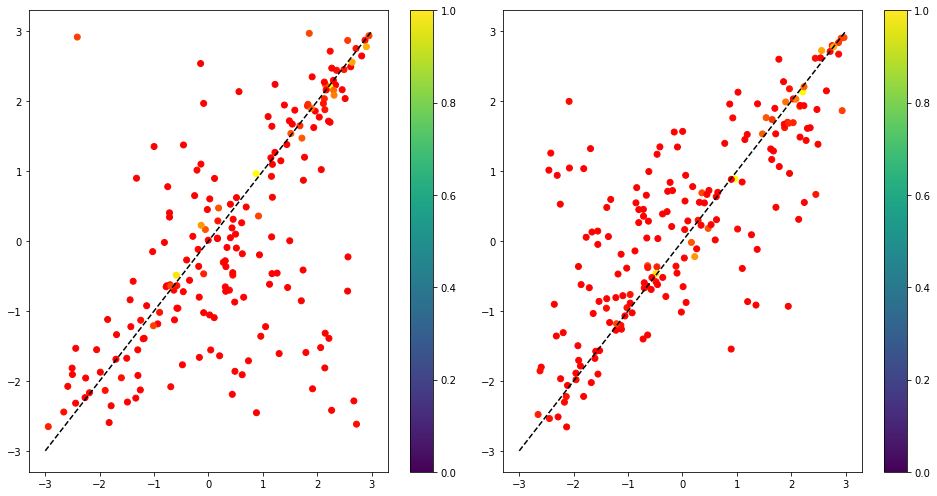

In [64]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.autumn
norm = Normalize(vmin= 0, vmax = 0.1)

figSize(7, 20)

for i in range(1, 3):
    plt.subplot(1, 3, i)
    x_vals = PDs[i-1, :, :].mean(axis = 1)
    y_vals = PDs[i, :, :].mean(axis = 1)
    plt.scatter(x_vals, y_vals, color = cmap(norm(scores.mean(axis = 0))))
    plt.plot([-3, 3], [-3, 3], color = 'k', linestyle = '--')
    plt.colorbar()
    
plt.tight_layout()

In [59]:
norm(scores.mean(axis = 0))

masked_array(data=[0.9020057 , 0.91168199, 0.92976337, 0.77361248,
                   0.90835683, 0.89279917, 0.90710454, 0.99809422,
                   0.94084049, 0.93906906, 0.89905427, 0.9202376 ,
                   0.88548431, 0.92170785, 0.9082343 , 0.93304773,
                   0.90616244, 0.91163936, 0.90751881, 0.90767826,
                   0.90722202, 0.89977434, 0.90705901, 0.89245646,
                   0.90661157, 0.90800706, 0.90433159, 0.94237189,
                   0.90764301, 0.91823956, 0.90724665, 0.9135791 ,
                   0.89415635, 0.91121863, 0.91429428, 0.91066722,
                   0.91362019, 0.90811452, 0.91472418, 0.90743909,
                   0.90774492, 0.90754924, 0.90643724, 0.90389352,
                   0.90696632, 0.89599875, 0.8961965 , 0.90821299,
                   0.91493347, 0.90682595, 0.9077561 , 0.90960285,
                   0.90869534, 0.90859394, 0.90731268, 0.90801727,
                   0.90671724, 0.90799629, 0.91646357, 0.90686

In [32]:
todo:

SyntaxError: invalid syntax (<ipython-input-32-dada2ae7d5d0>, line 1)

# across-session trends

In [198]:
files   = glob.glob('../data/session_PDs/*')
timelen = len(files)

pvals   = np.zeros((timelen, n_chans))
PDs     = np.zeros((timelen, n_chans, n_bootstraps))
coefs   = np.zeros((timelen, n_chans, n_bootstraps, 3))

for i, file in enumerate(files):
    dat               = loadmat(file)
    pvals[i, :]       = dat['pvals']
    r1, r2            = dat['weights'][:, :, 1], dat['weights'][:, :, 2] 
    coefs[i, :, :, :] = dat['weights']
    PDs[i, :, :]      = np.arctan2(r2, r1)

Number of channels with significant non-uniformity (uncorrected):  146


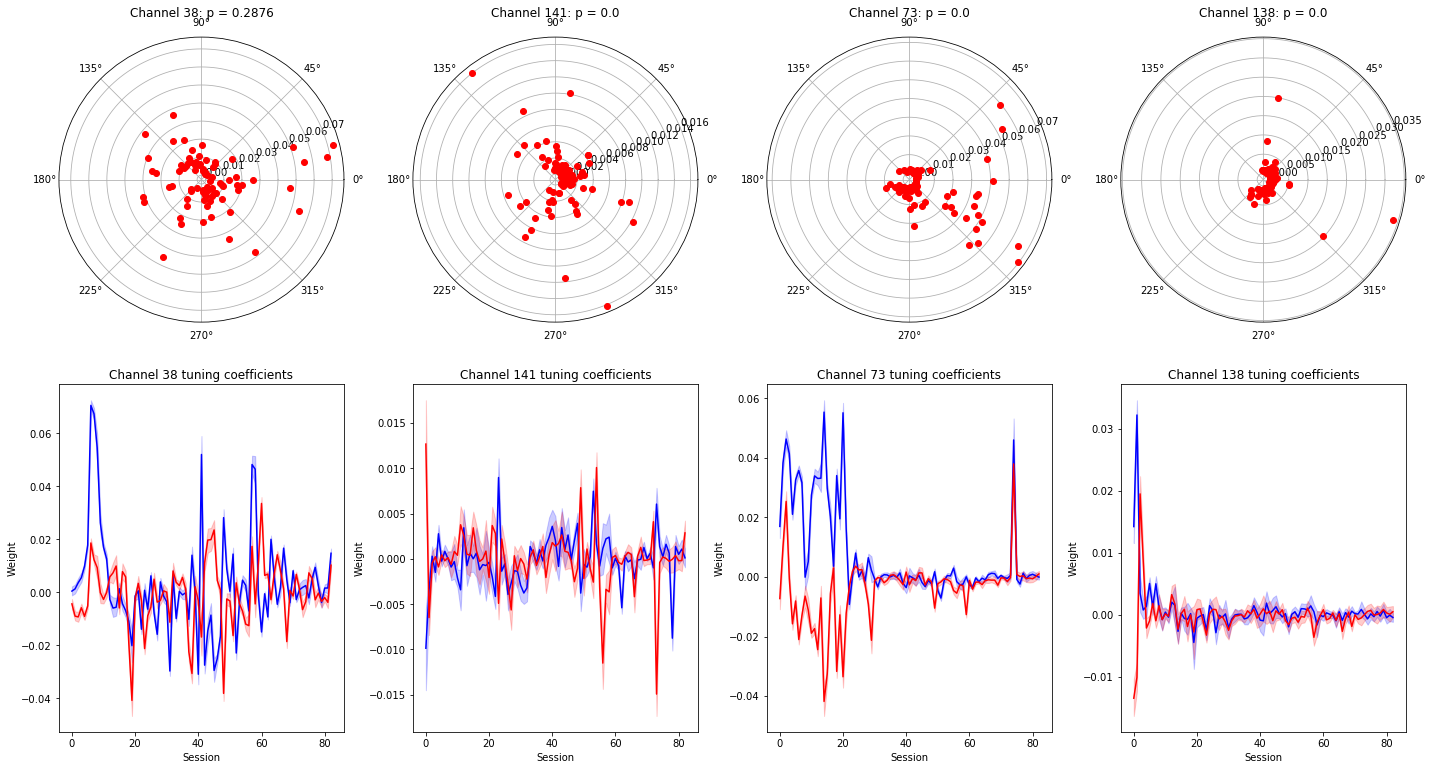

In [321]:
from rayleigh import rayleightest

figSize(11, 20)

np.random.seed(1)

circ_pvalue = np.zeros((n_chans,))
channels    = np.random.randint(0, n_chans, 4)

for ch in range(n_chans):
    theta = np.mean(PDs[:, ch, :].squeeze(), axis = 1)
    r     = np.linalg.norm(np.mean(coefs[:, ch, :, :], axis = 1)[:, 1:], axis = 1)
    circ_pvalue[ch] = rayleightest(theta)


for i, ch in zip(range(1, 5), channels):
    theta = np.mean(PDs[:, ch, :].squeeze(), axis = 1)
    r     = np.linalg.norm(np.mean(coefs[:, ch, :, :], axis = 1)[:, 1:], axis = 1)

    plt.subplot(2, 4, i, projection='polar')
    for j in range(timelen):
        plt.polar(theta[j], r[j], 'ro')
    plt.title('Channel ' + str(ch + 1) + ': p = ' + str(np.round(circ_pvalue[ch], 4)))
    
    
for i, ch in zip(range(5, 9), channels):
    plt.subplot(2,4,i)
    r1    = coefs[:, ch, :, 1]
    r2    = coefs[:, ch, :, 2]

    #plt.subplot(2, 2, i, projection='polar':
    plotCI(r1.T, color = 'b')
    plotCI(r2.T, color = 'r')
    plt.title('Channel ' + str(ch + 1) + ' tuning coefficients')
    plt.xlabel('Session')
    plt.ylabel('Weight')
    
plt.tight_layout()
print('Number of channels with significant non-uniformity (uncorrected): ', sum(circ_pvalue < 0.05))